# Collaboration and Competition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment

## Start the environment!

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents.
Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
class Unity:
    __FILE_NAME = 'Tennis_Linux/Tennis.x86_64'

    def __init__(self):
        self._env = UnityEnvironment(file_name=Unity.__FILE_NAME)
        self._brain_name = self.env.brain_names[0]
        self._brain = self.env.brains[self._brain_name]


    @property
    def env(self):
        return self._env

    @property
    def brain(self):
        return self._brain

    @property
    def brain_name(self):
        return self._brain_name

In [3]:
unity = Unity()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Randomly Pick Actions

In the next piece of code cell, controlling the agent and receiving feedback from the environment is shown.

In the environment you started above, once the cell is executed, the agent will start interacting with the environment.

In [8]:
class CrazyCompetition:
    __MAX_TIMESTEPS = 2000

    def __init__(self, unity, num_episodes, train_mode=True):
        """
        Initialize the crazy agent.

        Args:
            unity (Unity): Unity wrapper for environment and brain.
            num_episodes (int): Number of episodes to run.
            train_mode (bool): Should be true if train mode is desired.
        """
        env_info = unity.env.reset(train_mode=train_mode)[unity.brain_name]

        self.unity = unity
        self.train_mode = train_mode
        self.num_episodes = num_episodes
        self.action_size = unity.brain.vector_action_space_size
        self.num_agents = len(env_info.agents)
        self.states = env_info.vector_observations

    def start(self):
        """
        Train/Test the worst agent.

        Note:
            This agent is called crazy competition as it takes random actions to interact with the environment.
            It does not learn from the environment as it does not use the states and rewards from it.
            It just saves the reward and hopes it has a good one.

            This is just for illustrative purposes.
        """
        for i in range(0, self.num_episodes):
            _ = self.unity.env.reset(train_mode=self.train_mode)[self.unity.brain_name]
            scores = np.zeros(self.num_agents)

            for t in range(CrazyCompetition.__MAX_TIMESTEPS):
                actions = np.random.randn(self.num_agents, self.action_size)
                actions = np.clip(actions, -1, 1)
                env_info = self.unity.env.step(actions)[self.unity.brain_name]
                next_states = env_info.vector_observations
                dones = env_info.local_done
                scores += env_info.rewards
                self.states = next_states

                if np.any(dones):
                    break

            print(f'\rEpisode {i}\tScore (max over agents): {np.max(scores)}', end='')

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        ax.legend(['Score'])
        plt.show()

Episode 99	Score (max over agents): 0.09000000171363354

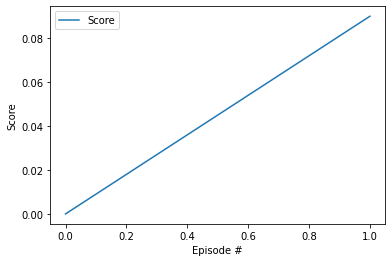

In [10]:
num_episodes = 100
crazy_competition = CrazyCompetition(unity, num_episodes, train_mode=False)
crazy_competition.start()

In [65]:
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [66]:
from collections import namedtuple, deque

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        Initialize a replay buffer.

        Note:
            The data structure used to save the experiences is a queue of size `buffer_size`.
            The queue is a queue of `namedtuples`.

        Args:
            action_size (int): Dimension of each action.
            buffer_size (int): Maximum size of buffer.
            batch_size (int): Size of each training batch.
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])

        random.seed(seed)
        np.random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """
        Add a new experience to memory.

        Args:
            state (numpy.array):
            action (numpy.array):
            reward (float):
            next_state (numpy.array):
            done (bool): A flag to indicate if episode is done.
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """
        Randomly sample a batch of experiences from memory.
        """
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """
        Return the current size of internal memory.
        """
        return len(self.memory)

In [67]:
class OUNoise:
    def __init__(self, size, seed, mu, theta, sigma):
        """
        Initialize parameters and noise process.

        Args:
            mu (float): Long-running mean.
            theta (float): Speed of mean reversion.
            sigma (float): Volatility parameter.
        """
        self.mu = mu * np.ones(size)
        self.state = copy.copy(self.mu)
        self.theta = theta
        self.sigma = sigma

        random.seed(seed)

        self.size = size
        self.reset()

    def reset(self):
        """
        Reset the internal state (= noise) to mean (mu).
        """
        self.state = copy.copy(self.mu)

    def sample(self):
        """
        Update internal state and return it as a noise sample.
        """
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [68]:
def hidden_init(model):
    """
    Computes the lower and upper bound of the uniform distribution.

    Args:
        model (nn.Module): A model with weights to update.
    """
    fan_in = model.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim

def weights_init(model):
    """
    Callback function to apply to a container model.

    Note: Only initializes nn.Linear modules.

    Args:
        model (nn.Module): A model with weights to update.
    """
    if type(model) == nn.Linear:
        model.weight.data.uniform_(*hidden_init(model))

In [69]:
class Actor(nn.Module):
    def __init__(self, input_size, output_size, seed):
        """
        Initialize actor class.

        Args:
            input_size (int): Dimension of the input size.
            output_size (int): Dimension of the output size.
            seed (int): Seed for random.
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ELU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 16),
            nn.ELU(),
            nn.Linear(16, output_size),
            nn.Tanh(),
        )

        self.reset_parameters()

    def forward(self, state):
        """
        Apply a forward pass to the network.

        Args:
            state (nn.Tensor): Input of the network.
        """
        if state.dim() == 1:
            state = torch.unsqueeze(state, 0)

        return self.model(state)

    def reset_parameters(self):
        """
        Apply weight initialization
        """
        self.model.apply(weights_init)

In [70]:
class Critic(nn.Module):
    def __init__(self, input_size, seed):
        """
        Initialize critic class.

        Args:
            input_size (int): Dimension of the input size.
            seed (int): Seed for random.
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ELU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 1),
        )

        self.reset_parameters()

    def forward(self, states, actions):
        """
        Apply a forward pass to the network.

        Args:
            state (nn.Tensor): Input of the network.
        """
        x = torch.cat((states, actions), dim=1)
        return self.model(x)

    def reset_parameters(self):
        """
        Apply weight initialization
        """
        self.model.apply(weights_init)

In [71]:
class ActorCritic:
    def __init__(self, n_agents, state_size, action_size, seed):
        """
        Initialize actor-critic class.

        Args:
            n_agents (int): Number of agents to train.
            state_size (int): Dimension of the state size.
            action_size (int): Dimension of the action size.
            seed (int): Seed for random.
        """
        critic_input_size = (state_size + action_size) * n_agents

        self.actor_regular = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)

        self.critic_regular = Critic(critic_input_size, seed).to(device)
        self.critic_target = Critic(critic_input_size, seed).to(device)

In [72]:
class Hyperparameters:
    GOAL = 0.51                 # Environment Goal
    AVG_OVER = 100              # Averaged score
    N_EPISODES = 3000           # Number of episode for training
    MAX_TIMESTEPS = 1000        # Max Timesteps
    BUFFER_SIZE = 12000         # Replay Buffer Size
    BATCH_SIZE = 256            # Minibatch Size
    GAMMA = 0.995               # Discount Gamma
    TAU = 1e-3                  # Soft Update Value
    LR_ACTOR = 1e-3             # Actor learning rate
    LR_CRITIC = 1e-3            # Critic learning rate
    UPDATE_EVERY = 2            # Update network every X intervals
    N_EXPERIENCES = 4           # Times to learn from batch of experiences
    OU_MU = 0.0                 # Noise parameters
    OU_SIGMA = 0.2              # Volatility
    OU_THETA = 0.15             # Speed of mean reversion
    EPSILON = 1                 # Noise exploration epsilon
    EPSILON_MIN = 0.01          # Noise exploration minimum
    EXPLORATION_STEPS = 12000   # Exploration steps related to N_EXPERIENCES

In [73]:
class DDPG:
    def __init__(self, agent_id, model, action_size, random_seed):
        """
        Initialize DDPG class.

        Args:
            agent_id (int): Agent's identifier
            model (nn.Module): Module to use.
            action_size (int): Dimension of the action size.
            seed (int): Seed for random.
        """
        self.id = agent_id

        self.actor_regular = model.actor_regular
        self.actor_target = model.actor_target
        self.actor_optimizer = optim.Adam(self.actor_regular.parameters(), lr=Hyperparameters.LR_ACTOR)

        self.critic_regular = model.critic_regular
        self.critic_target = model.critic_target
        self.critic_optimizer = optim.Adam(self.critic_regular.parameters(), lr=Hyperparameters.LR_CRITIC)

        self.noise = OUNoise(
            action_size,
            random_seed,
            Hyperparameters.OU_MU,
            Hyperparameters.OU_THETA,
            Hyperparameters.OU_SIGMA,
        )

        self.deep_copy(self.actor_target, self.actor_regular)
        self.deep_copy(self.critic_target, self.critic_regular)

    def act(self, states, noise_value, add_noise=True):
        """
        Act upon the give state, and add noise if need be.

        Args:
            states (nn.Tensor): Tensor of states.
            noise_value (float): Amount of noise to add.
            add_noise (bool): Flag to add noise.
        """

        states = torch.from_numpy(states).float().to(device)
        self.actor_regular.eval()

        with torch.no_grad():
            action = self.actor_regular(states).cpu().data.numpy()

        self.actor_regular.train()

        if add_noise:
            # Include exploration noise
            action += noise_value * self.noise.sample()

        # Clip action to the right interval
        return np.clip(action, -1, 1)

    def learn(self, agent_id, experiences, all_next_actions, all_actions):
        """
        Update value parameters using given batch of experience tuples.

        Args:
            agent_id (int): Agent's identifier.
            experiences (Tuple[torch.Variable]): Tuple of (state, action, reward, next_state, done) tuples
            all_next_actions (list): List of all next actions.
            all_actions (list): List of all next actions.
        """

        states, actions, rewards, next_states, dones = experiences

        # Update the critic neural network
        self.critic_optimizer.zero_grad()
        agent_id = torch.tensor([agent_id]).to(device)
        actions_next = torch.cat(all_next_actions, dim=1).to(device)

        with torch.no_grad():
            Q_targets_next = self.critic_target(next_states, actions_next)

        Q_expected = self.critic_regular(states, actions)
        Q_targets = rewards.index_select(1, agent_id) + (Hyperparameters.GAMMA * Q_targets_next * (1 - dones.index_select(1, agent_id)))

        loss = torch.nn.MSELoss()
        critic_loss = loss(Q_expected, Q_targets.detach())

        critic_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.critic_regular.parameters(), 1)
        self.critic_optimizer.step()

        self.actor_optimizer.zero_grad()

        actions_pred = [ actions if i == self.id else actions.detach() for i, actions in enumerate(all_actions) ]
        actions_pred = torch.cat(actions_pred, dim=1).to(device)
        actor_loss = -self.critic_regular(states, actions_pred).mean()

        actor_loss.backward()

        self.actor_optimizer.step()

        self.soft_update(self.critic_regular, self.critic_target)
        self.soft_update(self.actor_regular, self.actor_target)

    def soft_update(self, local_model, target_model):
        """
        Soft update model weights.

        Note:
            θ_target = τ * θ_local + (1 - τ) * θ_target

        Args:
            local_model (nn.Model): Model to copy the weights from.
            target_model (nn.Model): Model to copy the weights to.
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(Hyperparameters.TAU * local_param.data + (1.0 - Hyperparameters.TAU) * target_param.data)

    def deep_copy(self, target, source):
        """
        Make a deep copy of weights

        Args:
            target (nn.Model): Target model.
            source (nn.Model): Source model.
        """
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

In [75]:
class MADDPG:
    def __init__(self, state_size, action_size, n_agents, random_seed):
        """
        Initialize a MADDPG agent according to the set of states and set of actions from the environment.

        Args:
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            n_agents (int): Number of agents.
            random_seed (int): Seed for random.

        Example:
            >>> dqn = MADDPG(state_size=37, action_size=4, n_agents=2, random_seed=89)
        """

        self.state_size = state_size
        self.action_size = action_size
        self.random_seed = random_seed
        self.n_agents = n_agents
        self.epsilon = Hyperparameters.EPSILON
        self.epsilon_min = Hyperparameters.EPSILON_MIN
        self.exploration_steps = Hyperparameters.EXPLORATION_STEPS
        self.epsilon_decay = (self.epsilon - self.epsilon_min * Hyperparameters.N_EXPERIENCES) / self.exploration_steps
        self.noise_enabled = True
        self.timestep_counter = 0
        self.agents = self.setup_agents()
        self.memory = ReplayBuffer(action_size, Hyperparameters.BUFFER_SIZE, Hyperparameters.BATCH_SIZE, random_seed)

    def train(self, env, brain_name):
        """
        Train the agent based on the environment and brain.

        Args:
            env (UnityEnvironment): Environment to train with.
            brain_name (str): Name of the brain.

        Example:
            >>> maddpg = MADDPG(37, 4, 2, random_seed=89)
            >>> maddpg.train(UnityEnvironment(file_name='/path/to/Environment.app'), 'EnvironmentBrain')
        """
        scores_deque = deque(maxlen=Hyperparameters.AVG_OVER)
        global_scores = []
        averaged_scores = []
        max_reward = 0.0

        avg_score = None

        for i_episode in range(1, Hyperparameters.N_EPISODES+1):
            env_info = env.reset(train_mode=True)[brain_name]
            states = env_info.vector_observations

            episode_rewards = []

            for t in range(Hyperparameters.MAX_TIMESTEPS):
                actions = self.act(states)
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done
                self.step(states, actions, rewards, next_states, dones)
                states = next_states
                episode_rewards.append(rewards)

                if np.any(dones):
                    break

            episode_reward = np.max(np.sum(np.array(episode_rewards), axis=0))

            scores_deque.append(episode_reward)
            global_scores.append(episode_reward)
            avg_score = np.mean(scores_deque)

            averaged_scores.append(avg_score)

            if episode_reward > max_reward:
                max_reward = episode_reward

            print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}', end="")

            if i_episode % 50 == 0:
                print(f'\rEpisode {i_episode}\t'
                      f'Average Score: {avg_score:.2f}\t'
                      f'Max Reward: {max_reward:.3f}\t'
                      f'Buffer: {(len(self.memory)/Hyperparameters.BUFFER_SIZE):.3f}\t'
                      f'Noise: {self.epsilon:.3f}\t'
                      f'Timestep: {self.timestep_counter}')

            if avg_score >= Hyperparameters.GOAL:
                print(f'\nEnvironment solved in {i_episode:d} episodes!\tAverage Score: {avg_score:.2f}')
                self.checkpoint()
                break

        return global_scores, avg_score

    def test(self, env, brain_name):
        """
        Test the agent based on the environment and brain.

        Args:
            env (UnityEnvironment): Environment to train with.
            brain_name (str): Name of the brain.

        Example:
            >>> dqn = MADDPG(37, 4, 2, random_seed=89)
            >>> dqn.test(UnityEnvironment(file_name='/path/to/Environment.app'), 'EnvironmentBrain')
        """

        self.load_weights()

        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations

        while True:
            actions = self.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            dones = env_info.local_done
            states = next_states

            if np.any(dones):
                break

    def setup_agents(self):
        """
        Create DDPG agents.
        """
        return [
            DDPG(i, ActorCritic(self.n_agents, self.state_size, self.action_size, self.random_seed), self.action_size, self.random_seed)
            for i in range(self.n_agents)
        ]

    def step(self, states, actions, rewards, next_states, dones):
        """
        Perform a step in the training process.

        Note:
            Firstly, saves the state in the replay experience buffer (state, action, reward, next_state, done).
            If there are enough numbers of samples in the memory, just sample one of them randomly, and help
            the learning process with it.

        Args:
            states (numpy.array): The current state from which an action has been selected.
            actions (numpy.array): The action selected based on the current state.
            rewards (float): The reward obtained after applying the action.
            next_states (numpy.array): The next state to which the environment will transition after applying the action.
            dones (numpy.array): An array of bool flags indicating agents are done.
        """
        states = states.reshape(1, -1)
        next_states = next_states.reshape(1, -1)
        self.memory.add(states, actions, rewards, next_states, dones)

        self.timestep_counter = self.timestep_counter + 1

        # Learn from our buffer if possible
        if len(self.memory) > Hyperparameters.BATCH_SIZE and self.timestep_counter % Hyperparameters.UPDATE_EVERY == 0:
            for _ in range(Hyperparameters.N_EXPERIENCES):
                experiences = [self.memory.sample() for _ in range(self.n_agents)]
                self.learn(experiences)

    def act(self, states):
        """
        Returns actions for given state as per current policy.

        Args:
            state (numpy.array): current state
        """
        actions = []
        for agent, state in zip(self.agents, states):
            action = agent.act(state, noise_value=self.epsilon, add_noise=self.noise_enabled)
            actions.append(action)

        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

        return np.array(actions).reshape(1, -1)

    def checkpoint(self):
        """
        Save actor and critic weights for each agent
        """
        for i, agent in enumerate(self.agents):
            torch.save(agent.actor_regular.state_dict(),  "actor_agent_{}.pth".format(i))
            torch.save(agent.critic_regular.state_dict(), "critic_agent_{}.pth".format(i))

    def load_weights(self):
        """
        Load weights from files.
        """

        for i, agent in enumerate(self.agents):
            agent.actor_regular.load_state_dict(torch.load("actor_agent_{}.pth".format(i)))
            agent.critic_regular.load_state_dict(torch.load("critic_agent_{}.pth".format(i)))

    def learn(self, experiences):
        """
        Update value parameters using given batch of experience tuples for each agent.

        Args:
            experiences (Tuple[torch.Variable]): Tuple of (state, action, reward, next_state, done) tuples
        """
        next_actions = []
        actions = []
        for i, agent in enumerate(self.agents):
            states, _ , _ , next_states, _ = experiences[i]
            agent_id = torch.tensor([i]).to(device)

            state = states.reshape(-1, self.action_size, self.state_size).index_select(1, agent_id).squeeze(1)
            action = agent.actor_regular(state)
            actions.append(action)

            next_state = next_states.reshape(-1, self.action_size, self.state_size).index_select(1, agent_id).squeeze(1)
            next_action = agent.actor_target(next_state)
            next_actions.append(next_action)

        # Call to the method learn for each agent using
        # the related experiences and all actions/next actions
        for i, agent in enumerate(self.agents):
            agent.learn(self.memory, i, experiences[i], next_actions, actions)

In [57]:
class Training:
    def start(unity):
        """
        Start training.

        Note:
            Train mode should be enabled.

        Args:
            unity (Unity): Environment to train with.
        """
        env_info = unity.env.reset(train_mode=True)[unity.brain_name]

        action_size = unity.brain.vector_action_space_size

        state_size = len(env_info.vector_observations[0])

        agent = MADDPG(state_size, action_size, len(env_info.agents), random_seed=89)
        scores, avg_score = agent.train(unity.env, unity.brain_name)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.plot(np.arange(len(scores)), [avg_score] * len(scores))
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        ax.legend(['Score', 'Average Score'])
        plt.show()

Episode 10	Average Score: 0.00	Max Reward: 0.000	Buffer: 0.01175	Noise: 0.989	Timestep: 141
Episode 20	Average Score: 0.00	Max Reward: 0.000	Buffer: 0.0235	Noise: 0.977	Timestep: 282
Episode 30	Average Score: 0.00	Max Reward: 0.000	Buffer: 0.035333333333333335	Noise: 0.966	Timestep: 424
Episode 40	Average Score: 0.00	Max Reward: 0.090	Buffer: 0.0485	Noise: 0.953	Timestep: 582
Episode 50	Average Score: 0.00	Max Reward: 0.100	Buffer: 0.06183333333333333	Noise: 0.941	Timestep: 742
Episode 60	Average Score: 0.01	Max Reward: 0.100	Buffer: 0.08083333333333333	Noise: 0.922	Timestep: 970
Episode 70	Average Score: 0.01	Max Reward: 0.100	Buffer: 0.09541666666666666	Noise: 0.908	Timestep: 1145
Episode 80	Average Score: 0.01	Max Reward: 0.100	Buffer: 0.10966666666666666	Noise: 0.895	Timestep: 1316
Episode 90	Average Score: 0.01	Max Reward: 0.100	Buffer: 0.12291666666666666	Noise: 0.882	Timestep: 1475
Episode 100	Average Score: 0.01	Max Reward: 0.100	Buffer: 0.1375	Noise: 0.868	Timestep: 1650
Episo

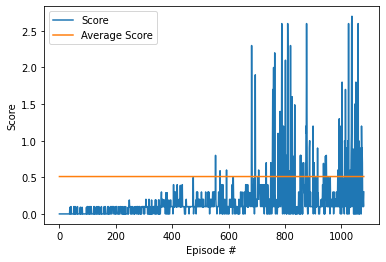

In [58]:
Training.start(unity)

In [62]:
class Evaluation:
    def start(unity):
        """
        Start evaluating.

        Note:
            Train mode should be disabled.

        Args:
            unity (Unity): Environment wrapper.
        """
        env_info = unity.env.reset(train_mode=False)[unity.brain_name]
        action_size = unity.brain.vector_action_space_size
        state_size = len(env_info.vector_observations[0])

        agent = MADDPG(state_size, action_size, len(env_info.agents), random_seed=89)
        agent.test(unity.env, unity.brain_name)

In [64]:
Evaluation.start(unity)